In [1]:
import cv2
import numpy as np
import glob
import re
from scipy.signal import find_peaks, detrend, butter, filtfilt
from scipy.fft import fft, fftfreq
from scipy.stats import variation
import matplotlib.pyplot as plt
import json
from datetime import datetime
import os
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [3]:
# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/frames', exist_ok=True)
os.makedirs('outputs/signals', exist_ok=True)

In [4]:
print("="*80)
print("EMBRYONIC MEDAKA FISH - COMPREHENSIVE CARDIAC ANALYSIS PIPELINE")
print("="*80)
print("Task: Process all 130 frames - Detect heart and estimate heart rate")
print("="*80)


EMBRYONIC MEDAKA FISH - COMPREHENSIVE CARDIAC ANALYSIS PIPELINE
Task: Process all 130 frames - Detect heart and estimate heart rate


In [5]:
print("\n" + "="*80)
print("STEP 1: LOADING ALL 130 FRAMES WITH TEMPORAL ANALYSIS")
print("="*80)


STEP 1: LOADING ALL 130 FRAMES WITH TEMPORAL ANALYSIS


In [6]:
# Load files and extract timing information from filenames
files = glob.glob('rawTiff/*.tif')

if len(files) == 0:
    print("ERROR: No TIFF files found in 'data/' directory")
    print("Please ensure data files are in the correct location")
    exit(1)

In [7]:
# Extract T values and sort by time
file_data = []
for f in files:
    match = re.search(r'--T(\d+)', f)
    if match:
        t_value = int(match.group(1))
        file_data.append((t_value, f))
    else:
        print(f"WARNING: Could not extract T value from {f}")

# Sort by T value (chronological order)
file_data.sort(key=lambda x: x[0])
files_sorted = [f for _, f in file_data]
t_values = [t for t, _ in file_data]

In [8]:
# Load all 130 frames
print("Loading 130 frames...")
frames = []
for i, f in enumerate(files_sorted):
    frame = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if frame is not None:
        frames.append(frame)
    if (i + 1) % 20 == 0:
        print(f"  Loaded {i + 1}/130 frames...")

print(f"✓ Successfully loaded {len(frames)} frames")
print(f"✓ Frame dimensions: {frames[0].shape}")
print(f"✓ Data type: {frames[0].dtype}")


Loading 130 frames...
  Loaded 20/130 frames...
  Loaded 40/130 frames...
  Loaded 60/130 frames...
  Loaded 80/130 frames...
  Loaded 100/130 frames...
  Loaded 120/130 frames...
✓ Successfully loaded 130 frames
✓ Frame dimensions: (2048, 2048)
✓ Data type: uint8


In [9]:
# Calculate timing information
time_diffs = np.diff(t_values)
print(f"\nTemporal Information:")
print(f"  T value range: {t_values[0]} to {t_values[-1]}")
print(f"  Total T difference: {t_values[-1] - t_values[0]}")
print(f"  Mean T difference between frames: {np.mean(time_diffs):.2f}")


Temporal Information:
  T value range: 15372985 to 15382995
  Total T difference: 10010
  Mean T difference between frames: 77.60


In [10]:
# Calculate frame rate (assuming T is in milliseconds based on typical values)
time_unit = 1e-3  # milliseconds to seconds
frame_intervals_sec = time_diffs * time_unit
mean_frame_interval = np.mean(frame_intervals_sec)
frame_rate = 1 / mean_frame_interval if mean_frame_interval > 0 else 30
total_duration = (t_values[-1] - t_values[0]) * time_unit

print(f"\nTiming Analysis:")
print(f"  Mean frame interval: {mean_frame_interval*1000:.2f} ms")
print(f"  Calculated frame rate: {frame_rate:.2f} fps")
print(f"  Total recording duration: {total_duration:.2f} seconds")



Timing Analysis:
  Mean frame interval: 77.60 ms
  Calculated frame rate: 12.89 fps
  Total recording duration: 10.01 seconds


In [11]:
print("\n" + "="*80)
print("STEP 2: EMBRYO DETECTION USING HOUGH CIRCLE TRANSFORM")
print("="*80)



STEP 2: EMBRYO DETECTION USING HOUGH CIRCLE TRANSFORM


In [12]:
# Use first frame for detection
frame = frames[0]

# Apply median blur to reduce noise while preserving edges
frame_blur = cv2.medianBlur(frame, 5)

# Apply CLAHE for better contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
frame_enhanced = clahe.apply(frame_blur)

print("Preprocessing:")
print("  ✓ Applied median blur (kernel=5)")
print("  ✓ Applied CLAHE for contrast enhancement")

Preprocessing:
  ✓ Applied median blur (kernel=5)
  ✓ Applied CLAHE for contrast enhancement


In [13]:
# Detect circles using Hough Circle Transform
print("\nApplying Hough Circle Transform...")
circles = cv2.HoughCircles(
    frame_blur, 
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=100,
    param1=50,
    param2=30,
    minRadius=50,
    maxRadius=250
)


Applying Hough Circle Transform...


✓ Detected 2 circular regions

Selected Embryo (Largest Circle):
  Center: (1138, 986)
  Radius: 233 pixels


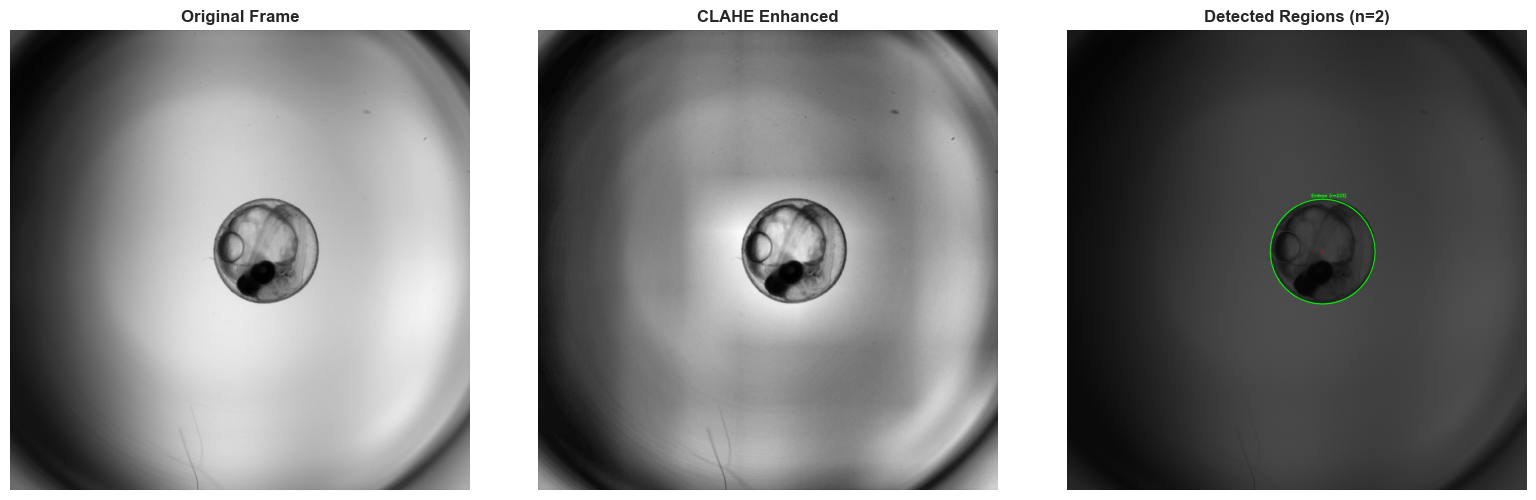

In [14]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    num_circles = len(circles[0])
    print(f"✓ Detected {num_circles} circular regions")
    
    # Select largest circle (most likely the embryo)
    radii = [c[2] for c in circles[0]]
    largest_idx = np.argmax(radii)
    x, y, r = circles[0][largest_idx]
    embryo_roi = {'x': int(x), 'y': int(y), 'radius': int(r)}
    
    print(f"\nSelected Embryo (Largest Circle):")
    print(f"  Center: ({x}, {y})")
    print(f"  Radius: {r} pixels")
    
    # Visualize detection
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    axes[0].imshow(frame, cmap='gray')
    axes[0].set_title('Original Frame', fontweight='bold', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(frame_enhanced, cmap='gray')
    axes[1].set_title('CLAHE Enhanced', fontweight='bold', fontsize=12)
    axes[1].axis('off')
    
    output = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    for i, (cx, cy, cr) in enumerate(circles[0]):
        color = (0, 255, 0) if i == largest_idx else (100, 100, 100)
        thickness = 3 if i == largest_idx else 1
        cv2.circle(output, (cx, cy), cr, color, thickness)
    cv2.circle(output, (x, y), 3, (0, 0, 255), -1)
    cv2.putText(output, f"Embryo (r={r})", (x-50, y-r-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    axes[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Detected Regions (n={num_circles})', fontweight='bold', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
#     plt.savefig('outputs/01_embryo_detection.png', dpi=150, bbox_inches='tight')
#     print("✓ Saved: outputs/01_embryo_detection.png")
#     plt.close()
    
else:
    print("❌ ERROR: No embryos detected")
    exit(1)

In [15]:
print("\n" + "="*80)
print("STEP 3: EXTRACTING EMBRYO ROI FROM ALL 130 FRAMES")
print("="*80)



STEP 3: EXTRACTING EMBRYO ROI FROM ALL 130 FRAMES


In [16]:
# Extract ROI for all frames
x, y, r = embryo_roi['x'], embryo_roi['y'], embryo_roi['radius']
crops = []
for i, frame in enumerate(frames):
    y1, y2 = max(0, y - r), min(frame.shape[0], y + r)
    x1, x2 = max(0, x - r), min(frame.shape[1], x + r)
    crop = frame[y1:y2, x1:x2]
    crops.append(crop)
print(f"✓ Extracted {len(crops)} ROI crops")
print(f"✓ ROI dimensions: {crops[0].shape}")

# Save ALL cropped images
print(f"Saving all {len(crops)} cropped images...")
for i in range(len(crops)):
    cv2.imwrite(f'outputs/frames/sample_crop_{i:03d}.png', crops[i])
print(f"✓ Saved all {len(crops)} cropped images to outputs/frames/")

✓ Extracted 130 ROI crops
✓ ROI dimensions: (466, 466)
Saving all 130 cropped images...
✓ Saved all 130 cropped images to outputs/frames/


In [17]:
print("\n" + "="*80)
print("STEP 4: ADAPTIVE HEART REGION DETECTION")
print("="*80)


STEP 4: ADAPTIVE HEART REGION DETECTION


In [18]:
def adaptive_region_detection(crops, frame_rate):
    """Robust heart region detection with adaptive thresholds"""
    print("Performing adaptive region detection...")
    
    # Calculate motion map from all frame differences
    diffs = [cv2.absdiff(crops[i], crops[i-1]) for i in range(1, len(crops))]
    avg_motion = np.mean(np.stack(diffs), axis=0)
    
    # Normalize motion map
    avg_motion_norm = (avg_motion - avg_motion.min()) / (avg_motion.max() - avg_motion.min() + 1e-8)
    avg_motion_smooth = cv2.GaussianBlur(avg_motion_norm, (15, 15), 3)
    
    # Multiple threshold strategies
    candidate_regions = []
    threshold_strategies = [
        ('percentile_85', np.percentile(avg_motion_smooth, 85)),
        ('percentile_75', np.percentile(avg_motion_smooth, 75)),
        ('mean_2std', np.mean(avg_motion_smooth) + 2 * np.std(avg_motion_smooth)),
    ]
    
    for strategy_name, threshold in threshold_strategies:
        mask = avg_motion_smooth > threshold
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            (mask * 255).astype(np.uint8), connectivity=8
        )
        
        print(f"  {strategy_name}: {num_labels-1} regions at threshold {threshold:.3f}")
        
        for i in range(1, min(num_labels, 10)):
            region_mask = (labels == i)
            region_size = stats[i, cv2.CC_STAT_AREA]
            
            if 5 < region_size < 1000:
                y_coords, x_coords = np.where(region_mask)
                center_x = int(np.mean(x_coords))
                center_y = int(np.mean(y_coords))
                intensity = np.mean(avg_motion_smooth[region_mask])
                
                candidate_regions.append({
                    'center': (center_x, center_y),
                    'mask': region_mask.copy(),
                    'intensity': intensity,
                    'size': region_size,
                    'strategy': strategy_name
                })
    
    # Remove duplicate regions
    unique_regions = []
    used_centers = []
    for region in candidate_regions:
        center = region['center']
        is_duplicate = False
        for used_center in used_centers:
            distance = np.sqrt((center[0]-used_center[0])**2 + (center[1]-used_center[1])**2)
            if distance < 10:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_regions.append(region)
            used_centers.append(center)
    
    print(f"✓ Found {len(unique_regions)} unique candidate regions")
    return unique_regions, avg_motion_smooth, diffs

In [19]:
# Apply adaptive region detection
candidate_regions, motion_map, diffs = adaptive_region_detection(crops, frame_rate)

Performing adaptive region detection...
  percentile_85: 29 regions at threshold 0.133
  percentile_75: 44 regions at threshold 0.128
  mean_2std: 5 regions at threshold 0.213
✓ Found 17 unique candidate regions


In [20]:
# Extract signals from all candidate regions
print(f"\nAnalyzing {len(candidate_regions)} candidate regions...")
region_signals = []
for i, region in enumerate(candidate_regions):
    signal = []
    for frame in crops:
        region_intensity = np.mean(frame[region['mask']])
        signal.append(region_intensity)
    region_signals.append(np.array(signal))



Analyzing 17 candidate regions...


In [21]:
# Select best region based on signal quality
best_region_idx = 0
best_score = -1
for i, signal in enumerate(region_signals):
    signal_var = np.var(signal)
    signal_diff = np.mean(np.abs(np.diff(signal)))
    score = signal_var * signal_diff
    if score > best_score:
        best_score = score
        best_region_idx = i

best_region = candidate_regions[best_region_idx]
cardiac_signal = region_signals[best_region_idx]
heart_location = best_region['center']

print(f"✓ Selected region {best_region_idx} as heart")
print(f"  Center: {heart_location}, Size: {best_region['size']} pixels")

# ==================

✓ Selected region 16 as heart
  Center: (46, 329), Size: 70 pixels


In [22]:
print("\n" + "="*80)
print("STEP 5: COMPREHENSIVE SIGNAL ANALYSIS (130 FRAMES)")
print("="*80)


STEP 5: COMPREHENSIVE SIGNAL ANALYSIS (130 FRAMES)


In [23]:
# Calculate frame-to-frame motion for all frames
global_motion = np.array([np.mean(d) for d in diffs])
frame_times = np.arange(len(global_motion)) / frame_rate

print("Signal Analysis:")
print(f"  Cardiac signal range: {np.min(cardiac_signal):.2f} to {np.max(cardiac_signal):.2f}")
print(f"  Global motion range: {np.min(global_motion):.3f} to {np.max(global_motion):.3f}")

# Save detailed signal data for all frames
signal_data = {
    'frame_numbers': list(range(len(frames))),
    'timestamps_ms': t_values,
    'time_seconds': [t * time_unit for t in t_values],
    'cardiac_signal': cardiac_signal.tolist(),
    'global_motion': global_motion.tolist(),
    'heart_region_intensity': cardiac_signal.tolist()
}

with open('outputs/signals/frame_analysis_data.json', 'w') as f:
    json.dump(signal_data, f, indent=2)


Signal Analysis:
  Cardiac signal range: 43.16 to 48.97
  Global motion range: 0.777 to 0.847


In [24]:
# Create CSV with all frame data
df = pd.DataFrame({
    'frame_number': range(len(frames)),
    'timestamp_ms': t_values,
    'time_seconds': [t * time_unit for t in t_values],
    'cardiac_intensity': cardiac_signal,
    'global_motion': [global_motion[i] if i < len(global_motion) else 0 for i in range(len(frames))]
})
df.to_csv('outputs/signals/frame_analysis_data.csv', index=False)

print("✓ Saved detailed frame analysis data")
print("  - outputs/signals/frame_analysis_data.json")
print("  - outputs/signals/frame_analysis_data.csv")


✓ Saved detailed frame analysis data
  - outputs/signals/frame_analysis_data.json
  - outputs/signals/frame_analysis_data.csv


In [25]:
# Method 1: Frequency Analysis (FFT)
signal_detrended = detrend(cardiac_signal)
N = len(signal_detrended)
T = 1 / frame_rate

# Apply windowing
window = np.hanning(N)
signal_windowed = signal_detrended * window

yf = fft(signal_windowed)
xf = fftfreq(N, T)[:N//2]
magnitude = 2.0/N * np.abs(yf[0:N//2])

# Find dominant frequency
freq_mask = (xf >= 0.8) & (xf <= 4.0)
if np.any(freq_mask):
    dominant_idx = np.argmax(magnitude[freq_mask])
    dominant_freq = xf[freq_mask][dominant_idx]
else:
    dominant_idx = np.argmax(magnitude[1:]) + 1
    dominant_freq = xf[dominant_idx]

heart_rate_fft = dominant_freq * 60

In [26]:
# Method 2: Peak Detection
def enhanced_peak_detection(signal, frame_rate):
    def butter_bandpass_filter(data, lowcut=0.8, highcut=4.0, fs=30, order=3):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)
    
    signal_filtered = butter_bandpass_filter(signal, lowcut=0.8, highcut=4.0, fs=frame_rate, order=3)
    min_peak_distance = int(frame_rate * 0.3)
    min_peak_prominence = 0.15 * np.std(signal_filtered)
    
    peaks, properties = find_peaks(signal_filtered, 
                                  distance=min_peak_distance,
                                  prominence=min_peak_prominence)
    return peaks, signal_filtered

peaks, signal_filtered = enhanced_peak_detection(cardiac_signal, frame_rate)
if len(peaks) >= 2:
    ibi = np.diff(peaks) / frame_rate
    mean_ibi = np.mean(ibi)
    heart_rate_peaks = 60 / mean_ibi
else:
    heart_rate_peaks = heart_rate_fft
    mean_ibi = 60 / heart_rate_fft
    ibi = [mean_ibi]

# Final consensus
if heart_rate_peaks and abs(heart_rate_fft - heart_rate_peaks) < 15:
    final_hr = (heart_rate_fft + heart_rate_peaks) / 2
else:
    final_hr = heart_rate_fft

# Validation
if 60 <= final_hr <= 180:
    validation_status = "VALID"
else:
    validation_status = "CHECK_REQUIRED"

In [27]:
print("\nHeart Rate Estimation Results:")
print(f"  FFT Method: {heart_rate_fft:.1f} BPM")
print(f"  Peak Detection: {heart_rate_peaks:.1f} BPM ({len(peaks)} beats)")
print(f"  Final Consensus: {final_hr:.1f} BPM")
print(f"  Validation: {validation_status}")




Heart Rate Estimation Results:
  FFT Method: 166.5 BPM
  Peak Detection: 169.7 BPM (28 beats)
  Final Consensus: 168.1 BPM
  Validation: VALID


In [28]:
# ============================================================================
# STEP 7: COMPREHENSIVE VISUALIZATION AND RESULTS
# ============================================================================
print("\n" + "="*80)
print("STEP 7: GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*80)


STEP 7: GENERATING COMPREHENSIVE VISUALIZATIONS


/var/folders/7x/0sq5q3rd48j9xm57xlcpm7sc0000gn/T/ipykernel_2724/1078124515.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


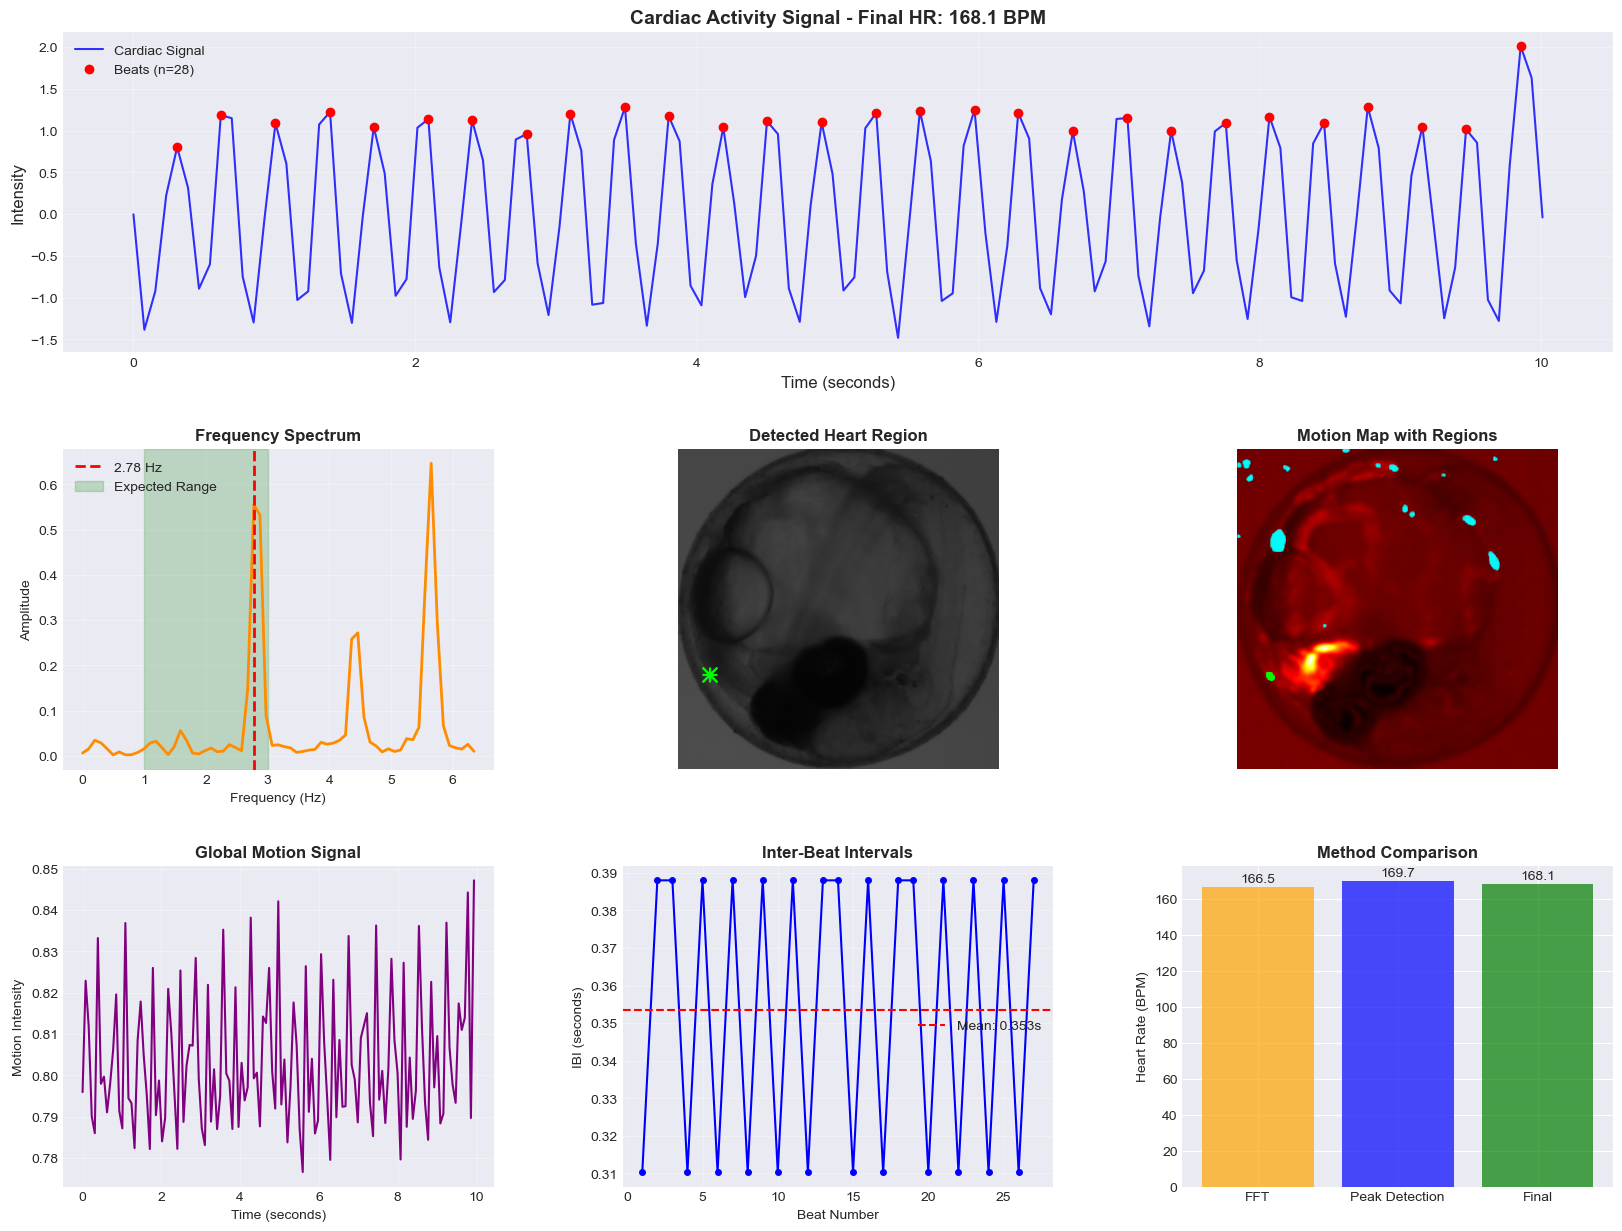

In [29]:
# Create comprehensive results figure
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Cardiac signal with peaks
ax1 = fig.add_subplot(gs[0, :])
time_vector = np.arange(len(signal_filtered)) / frame_rate
ax1.plot(time_vector, signal_filtered, 'b-', linewidth=1.5, alpha=0.8, label='Cardiac Signal')
if len(peaks) > 0:
    ax1.plot(peaks / frame_rate, signal_filtered[peaks], 'ro', markersize=6, label=f'Beats (n={len(peaks)})')
ax1.set_title(f'Cardiac Activity Signal - Final HR: {final_hr:.1f} BPM', fontweight='bold', fontsize=14)
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Intensity', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Frequency spectrum
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(xf, magnitude, 'darkorange', linewidth=2)
ax2.axvline(dominant_freq, color='red', linestyle='--', linewidth=2, label=f'{dominant_freq:.2f} Hz')
ax2.axvspan(1.0, 3.0, alpha=0.2, color='green', label='Expected Range')
ax2.set_title('Frequency Spectrum', fontweight='bold', fontsize=12)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Heart region visualization
ax3 = fig.add_subplot(gs[1, 1])
embryo_with_heart = cv2.cvtColor(crops[0], cv2.COLOR_GRAY2BGR)
region_mask = best_region['mask']
overlay = embryo_with_heart.copy()
overlay[region_mask] = [0, 0, 255]
cv2.addWeighted(overlay, 0.3, embryo_with_heart, 0.7, 0, embryo_with_heart)
cv2.drawMarker(embryo_with_heart, heart_location, (0, 255, 0), cv2.MARKER_STAR, 20, 2)
ax3.imshow(cv2.cvtColor(embryo_with_heart, cv2.COLOR_BGR2RGB))
ax3.set_title('Detected Heart Region', fontweight='bold', fontsize=12)
ax3.axis('off')

# Plot 4: Motion map with regions
ax4 = fig.add_subplot(gs[1, 2])
ax4.imshow(motion_map, cmap='hot')
for i, region in enumerate(candidate_regions):
    color = 'lime' if i == best_region_idx else 'cyan'
    alpha = 0.8 if i == best_region_idx else 0.3
    y, x = np.where(region['mask'])
    ax4.scatter(x, y, c=color, s=1, alpha=alpha)
ax4.set_title('Motion Map with Regions', fontweight='bold', fontsize=12)
ax4.axis('off')

# Plot 5: Global motion signal
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(frame_times, global_motion, 'purple', linewidth=1.5)
ax5.set_title('Global Motion Signal', fontweight='bold', fontsize=12)
ax5.set_xlabel('Time (seconds)')
ax5.set_ylabel('Motion Intensity')
ax5.grid(True, alpha=0.3)


# Plot 6: Inter-beat intervals
ax6 = fig.add_subplot(gs[2, 1])
if len(ibi) > 1:
    ax6.plot(range(1, len(ibi)+1), ibi, 'bo-', markersize=4)
    ax6.axhline(np.mean(ibi), color='r', linestyle='--', label=f'Mean: {np.mean(ibi):.3f}s')
    ax6.set_title('Inter-Beat Intervals', fontweight='bold', fontsize=12)
    ax6.set_xlabel('Beat Number')
    ax6.set_ylabel('IBI (seconds)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
# Plot 7: Method comparison
ax7 = fig.add_subplot(gs[2, 2])
methods = ['FFT', 'Peak Detection', 'Final']
rates = [heart_rate_fft, heart_rate_peaks, final_hr]
colors = ['orange', 'blue', 'green']
bars = ax7.bar(methods, rates, color=colors, alpha=0.7)
ax7.set_ylabel('Heart Rate (BPM)')
ax7.set_title('Method Comparison', fontweight='bold', fontsize=12)
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 1, f'{rate:.1f}', ha='center', va='bottom')

plt.tight_layout()

In [30]:
plt.tight_layout()
plt.savefig('outputs/07_comprehensive_results.png', dpi=150, bbox_inches='tight')
print("✓ Saved: outputs/07_comprehensive_results.png")

✓ Saved: outputs/07_comprehensive_results.png


<Figure size 1200x600 with 0 Axes>